In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import geopandas as gpd
from numba import njit, prange
from pyproj import Transformer
from geodatasets import get_path
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns


In [57]:
DATA_PATH = '/home/lennartz/data/nypd-collision/Motor_Vehicle_Collisions_-_Crashes_20250627.csv'

percentage of rows with invalid coordinates: 0.25%


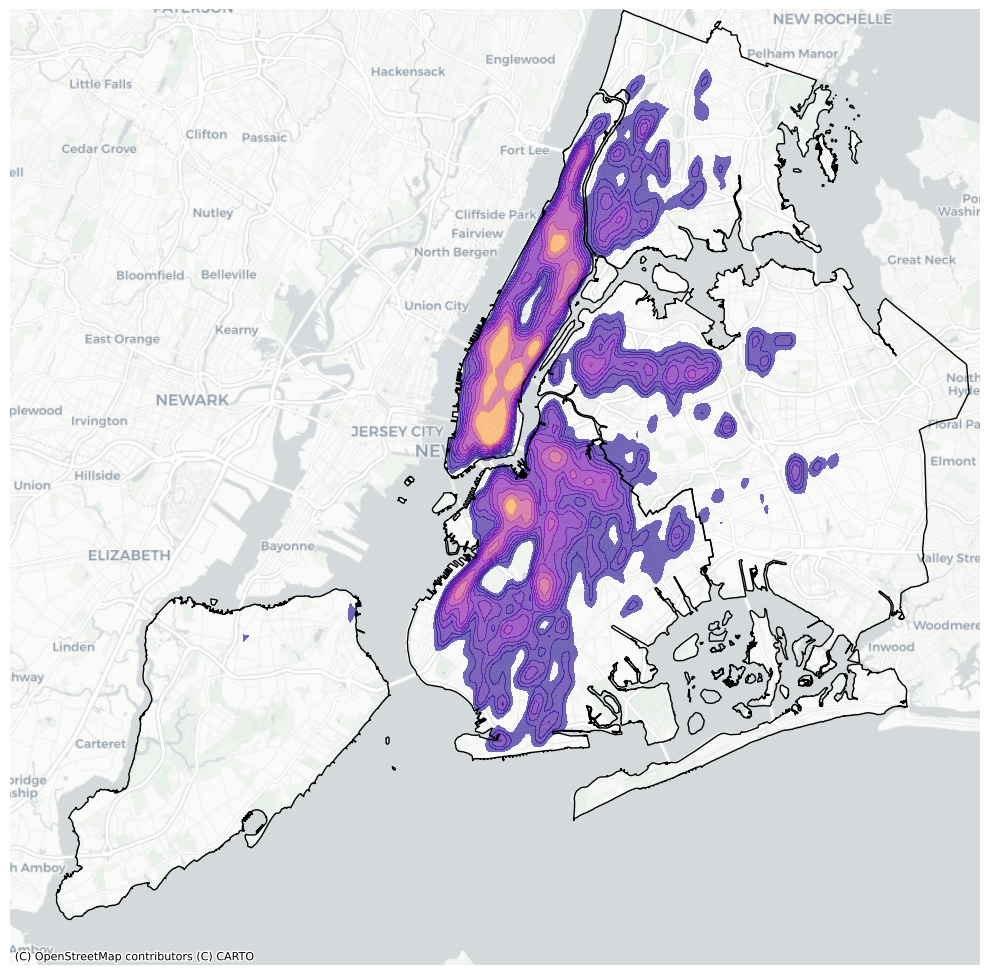

In [ ]:
# Load the data
df = pd.read_csv(DATA_PATH, parse_dates=['CRASH DATE'])

# GeoDataFrame from lat/lon
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['LONGITUDE'], df['LATITUDE']),
    crs="EPSG:4326"
)

# some filtering
invalid_rows = gdf[(gdf.geometry.x == 0) | (gdf.geometry.y == 0)]
print(f"percentage of rows with invalid coordinates: {len(invalid_rows) / len(gdf) * 100:.2f}%")
gdf = gdf[(gdf.geometry.x != 0) & (gdf.geometry.y != 0)]

# Reproject to Web Mercator: transforms coords into EPSG:3857
gdf = gdf.to_crs(epsg=3857)  

nybb = gpd.read_file(get_path("nybb")).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))

# borough outlines
nybb.boundary.plot(ax=ax, linewidth=1, edgecolor='black')

sns.kdeplot(
    x=gdf.geometry.x,
    y=gdf.geometry.y,
    ax=ax,
    cmap="plasma",
    alpha=0.6,
    fill=True,
    thresh=0.2,
    levels=10,
    bw_adjust=0.2,
)



# OpenStreetMap basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    crs=gdf.crs
)
ax.set_axis_off()
plt.tight_layout()
plt.show()


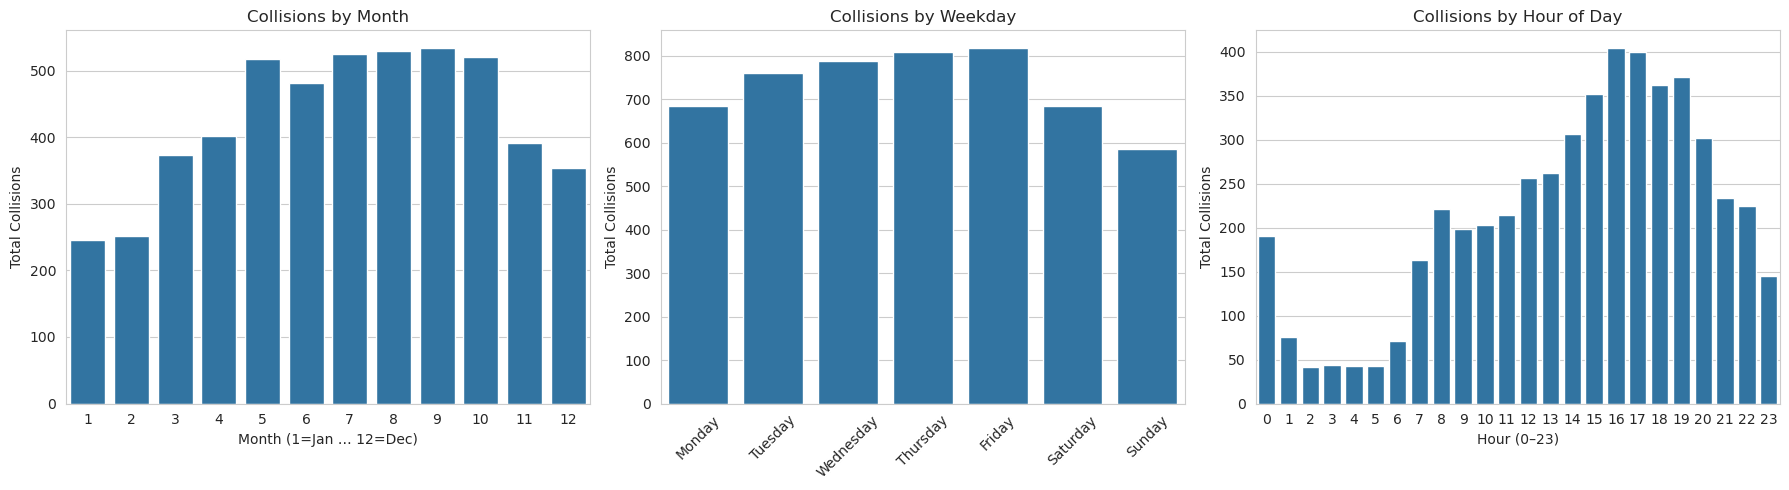

In [ ]:

# Load the data
df = pd.read_csv(DATA_PATH, parse_dates=['CRASH DATE'])

# datetie formatting
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M', errors='coerce').dt.time

# Extract period‐fields
df['month']   = df['CRASH DATE'].dt.month               # 1–12
df['weekday'] = df['CRASH DATE'].dt.day_name()          # Monday–Sunday
df['hour'] = (
    pd.to_datetime(df['CRASH TIME'],
                   format='%H:%M:%S',
                   errors='coerce')
      .dt.hour
)
# Compute counts
monthly_counts  = df['month'].value_counts().sort_index()
weekday_order   = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_counts  = df['weekday'].value_counts().reindex(weekday_order)
hourly_counts   = df['hour'].value_counts().sort_index()

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Month ---
sns.barplot(
    x=monthly_counts.index,
    y=monthly_counts.values,
    ax=axes[0],
)
axes[0].set_title("Collisions by Month")
axes[0].set_xlabel("Month (1=Jan … 12=Dec)")
axes[0].set_ylabel("Total Collisions")

# --- Weekday ---
sns.barplot(
    x=weekday_counts.index,
    y=weekday_counts.values,
    ax=axes[1],
)
axes[1].set_title("Collisions by Weekday")
axes[1].set_xlabel("")
axes[1].set_ylabel("Total Collisions")
axes[1].tick_params(axis='x', rotation=45)

# --- Hour ---
sns.barplot(
    x=hourly_counts.index,
    y=hourly_counts.values,
    ax=axes[2],
)
axes[2].set_title("Collisions by Hour of Day")
axes[2].set_xlabel("Hour (0–23)")
axes[2].set_ylabel("Total Collisions")

plt.tight_layout()
plt.show()



/tmp/ipykernel_1519331/3698064578.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'], errors='coerce').dt.time
/tmp/ipykernel_1519331/3698064578.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


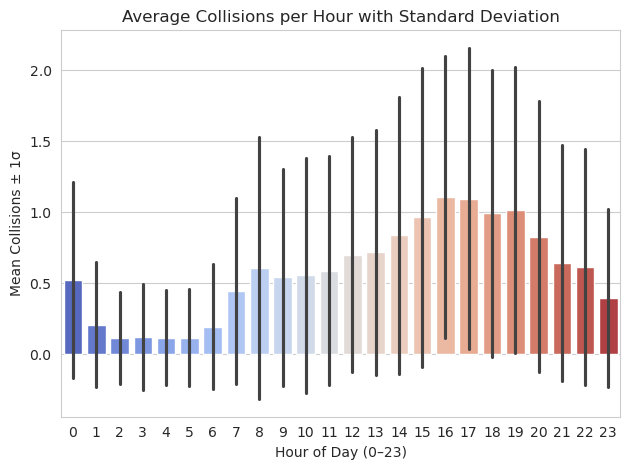

In [ ]:
import numpy as np

# Load the data
df = pd.read_csv(DATA_PATH, parse_dates=['CRASH DATE'])
# Parse time and combine with date
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'], errors='coerce').dt.time
df = df.dropna(subset=['CRASH TIME'])
df['datetime'] = pd.to_datetime(
    df['CRASH DATE'].dt.strftime('%Y-%m-%d') + ' ' + df['CRASH TIME'].astype(str)
)

# Extract date and hour if not already present
df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour
# Compute collisions per hour for each day
hourly_counts = df.groupby(['date', 'hour']).size().reset_index(name='count')

# Build full grid of every date and every hour (0–23):
all_dates = pd.date_range(df['date'].min(), df['date'].max(), freq='D').date
all_hours = range(24)

full_idx = pd.MultiIndex.from_product(
    [all_dates, all_hours],
    names=['date', 'hour']
)
full_grid = pd.DataFrame(index=full_idx).reset_index()

# Merge real counts onto grid, fill missing with 0
hourly_full = (
    full_grid
    .merge(hourly_counts, on=['date','hour'], how='left')
    .fillna({'count': 0})
)

sns.barplot(
    x='hour',
    y='count',
    data=hourly_full,
    estimator=np.mean,
    errorbar=('sd', 1),
    palette='coolwarm'
)
plt.title('Average Collisions per Hour with Standard Deviation')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Mean Collisions ± 1σ')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

percentage of rows with invalid coordinates: 0.25%


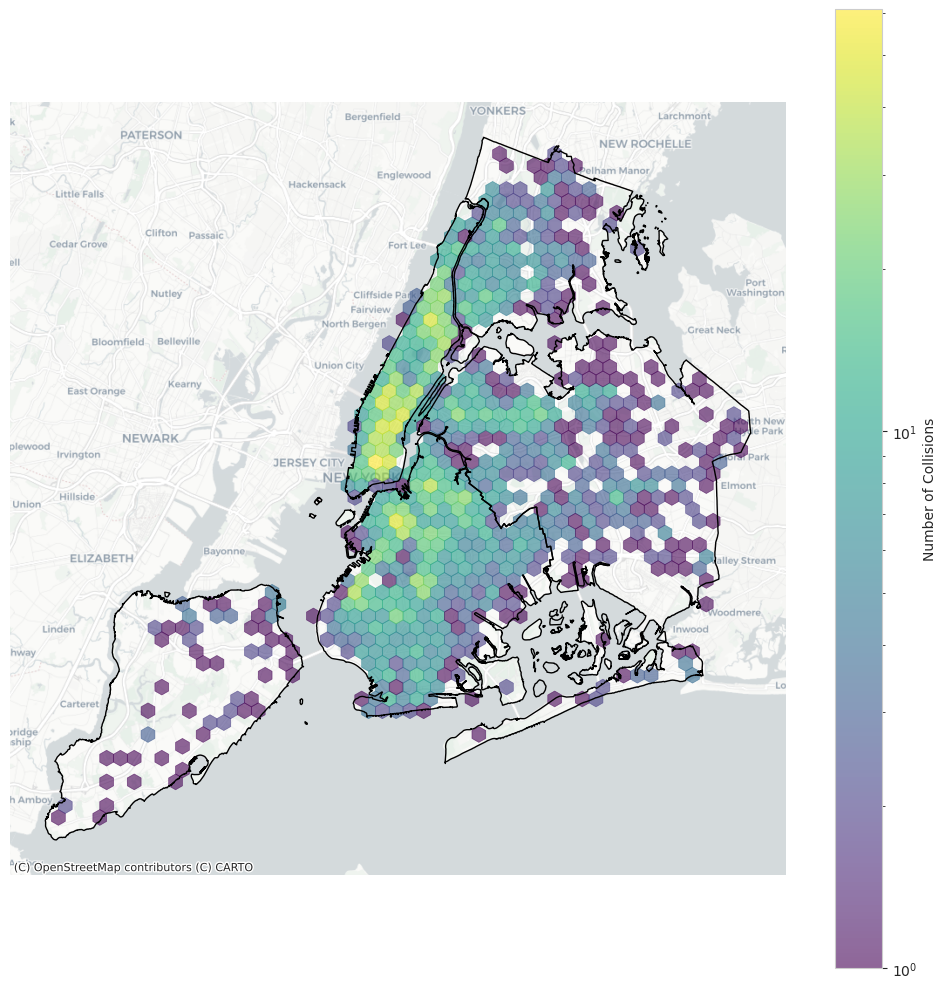

In [ ]:
# Load the data
df = pd.read_csv(DATA_PATH, parse_dates=['CRASH DATE'])

# GeoDataFrame from lat/lon
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['LONGITUDE'], df['LATITUDE']),
    crs="EPSG:4326"
)

# some filtering
invalid_rows = gdf[(gdf.geometry.x == 0) | (gdf.geometry.y == 0)]
print(f"percentage of rows with invalid coordinates: {len(invalid_rows) / len(gdf) * 100:.2f}%")
gdf = gdf[(gdf.geometry.x != 0) & (gdf.geometry.y != 0)]

# Reproject to Web Mercator: transforms coords into EPSG:3857
gdf = gdf.to_crs(epsg=3857)  

nybb = gpd.read_file(get_path("nybb")).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))

# borough outlines
nybb.boundary.plot(ax=ax, linewidth=1, edgecolor='black')

# hexbin plot
hb = ax.hexbin(
    gdf.geometry.x,
    gdf.geometry.y,
    gridsize=50,
    linewidths=0.5,
    bins='log',
    mincnt=1,
    alpha=0.6,
    cmap='viridis'
)

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Number of Collisions')


# OpenStreetMap basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    crs=gdf.crs
)
ax.set_axis_off()
plt.tight_layout()
plt.show()
